# This notebook generates simulated data and figures to highlight the concepts discussed in the aperiodic recommendations paper


### Issue

<>

### Solution

<>

### Related Work

The following papers include discussion of this topic:

- [LINK](LINK), AUTHORS, YEAR

### Related Discussion / Examples

The following examples discuss related topics:
-  [LINK](LINK), DESCRIPTION

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mne.time_frequency import tfr_array_multitaper
import os
import seaborn as sns
import string
import random


from neurodsp.sim import (
    sim_combined,
    sim_synaptic_current,
    sim_synaptic_kernel,
    sim_knee,
    sim_peak_oscillation,
    sim_powerlaw,
    sim_oscillation,
)
from neurodsp.spectral import compute_spectrum
from neurodsp.plts.time_series import plot_time_series
from neurodsp.utils import create_times

import fooof
from fooof.plts import plot_spectra
from fooof.analysis import get_band_peak_fg
from fooof.utils import trim_spectrum

/var/folders/5j/h9q625yn13vfynsjc2bymdy00000gn/T/ipykernel_68867/2887209254.py:26: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  import fooof


In [2]:
# Add path and import custom code for the project
import sys

sys.path.append("code")

### Settings

In [3]:
import seaborn as sns

sns.set_context("talk")

In [4]:
# Set random seed
random.seed(420)

In [5]:
# Set whether to save out figures
FIG_DIR = "../figures"
SAVE_FIG = False

_________________

## Figure x in paper (Belonging to Recommendation 1)

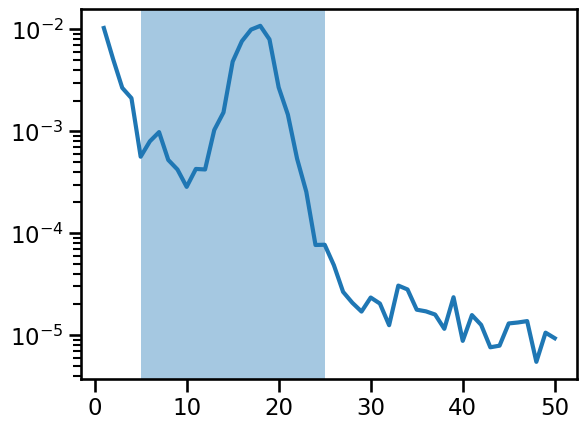

In [6]:
## Simulate timeseries as a combination of aperiodic and periodic components
sim_components = {"sim_knee": {"exponent1": 0, "exponent2": -2, "knee": 0}}
fs = 1000
n_seconds = 10
ap_sig = sim_knee(n_seconds, fs, **sim_components["sim_knee"])
sig = sim_peak_oscillation(ap_sig, fs, freq=18, bw=3.5, height=2.5)

## Compute the power spectrum using Welch's
freqs, powers = compute_spectrum(
    sig, fs=fs, f_range=(1, 50), avg_type="median", nperseg=fs, noverlap=fs / 2
)

plt.semilogy(freqs, powers, linewidth=3)
plt.axvspan(5, 25, alpha=0.4)

Text(0, 0.5, 'log(Power)')

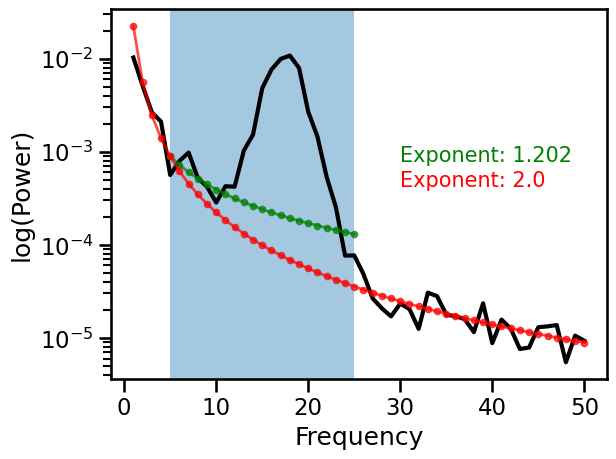

In [7]:
init_settings = {"peak_width_limits": (2, 12), "peak_threshold": 2.5}

fit_settings = {"freq_range": (1, 50)}
fm_wide = fooof.FOOOF(**init_settings)
fm_wide.fit(freqs=freqs, power_spectrum=powers, **fit_settings)
wide_exp = np.round(fm_wide.get_results().aperiodic_params[1], decimals=3)
fm_wide_ap_fit = fm_wide.get_model(component="aperiodic", space="linear")
fm_wide_freqs = fm_wide.freqs

fit_settings = {"freq_range": (5, 25)}
fm_beta = fooof.FOOOF(**init_settings)
fm_beta.fit(freqs=freqs, power_spectrum=powers, **fit_settings)
beta_exp = np.round(fm_beta.get_results().aperiodic_params[1], decimals=3)
fm_beta_ap_fit = fm_beta.get_model(component="aperiodic", space="linear")
fm_beta_freqs = fm_beta.freqs

plt.semilogy(freqs, powers, linewidth=3, color="k")
plt.semilogy(
    fm_beta_freqs,
    fm_beta_ap_fit,
    linewidth=2,
    marker=".",
    alpha=0.7,
    color="green",
)
plt.semilogy(
    fm_wide_freqs,
    fm_wide_ap_fit,
    linewidth=2,
    marker=".",
    alpha=0.7,
    color="red",
)
plt.text(
    x=30, y=powers[5], s=f"Exponent: {beta_exp}", color="green", fontsize=15
)
plt.text(
    x=30, y=powers[10], s=f"Exponent: {wide_exp}", color="red", fontsize=15
)
plt.axvspan(5, 25, alpha=0.4)
plt.xlabel("Frequency")
plt.ylabel("log(Power)")

___________________________________________________

## Figure x in paper (Belonging to Recommendation 2)

### Simulate neural time series

In [8]:
sim_components = {
    "sim_powerlaw": {"exponent": -2},
    "sim_oscillation": [{"freq": 8}, {"freq": 20}],
}
sig = sim_combined(n_seconds=1, fs=500, components=sim_components)

times = create_times(n_seconds=1, fs=500)

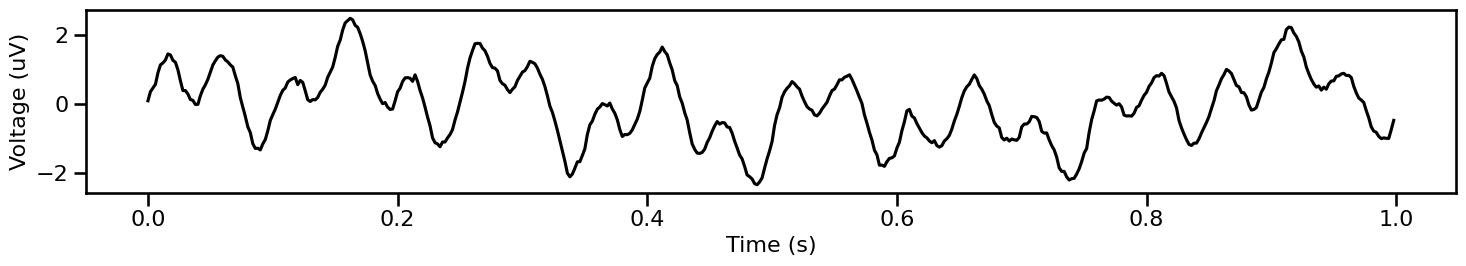

In [9]:
plot_time_series(times, sig)

### Zero-pad and mirror-pad time-signal

In [10]:
zero_pad = np.zeros(100)  # Add 100 datapoints => 200 ms
mirror_pad_beg = np.flip(sig[:100])
mirror_pad_end = np.flip(sig[-100:])

In [11]:
sig_zero = np.concatenate((zero_pad, sig, zero_pad))
sig_mirror = np.concatenate((mirror_pad_beg, sig, mirror_pad_end))

times_pad = create_times(n_seconds=1.4, fs=500)

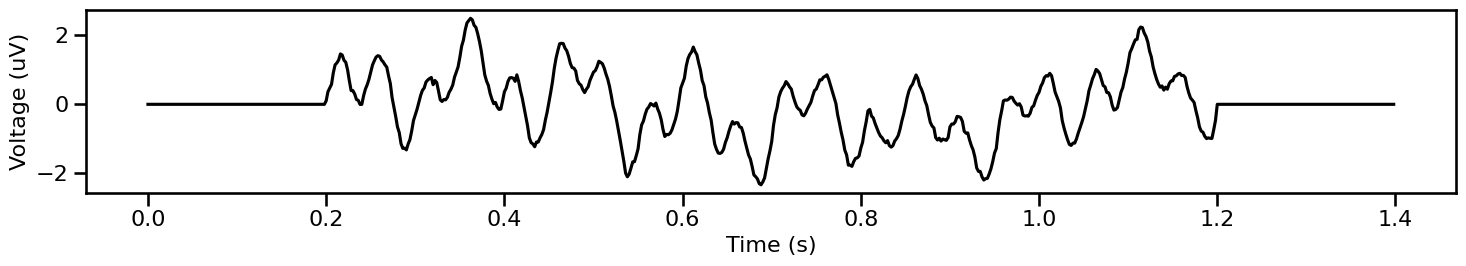

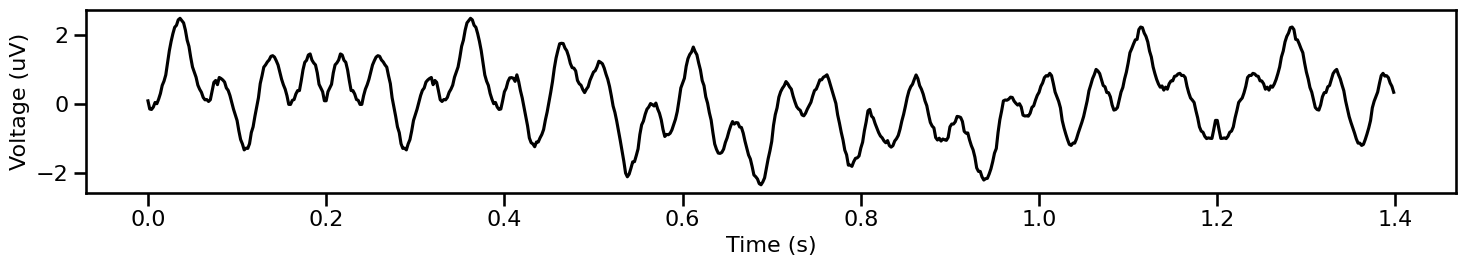

In [12]:
plot_time_series(times_pad, sig_zero)
plot_time_series(times_pad, sig_mirror)

In [13]:
# For plotting purposes: add nans to original signal so it's alligned with the padded ones
nan_pad = np.full(100, np.nan)  # Add 100 datapoints => 200 ms
sig_ori = np.concatenate((nan_pad, sig, nan_pad))

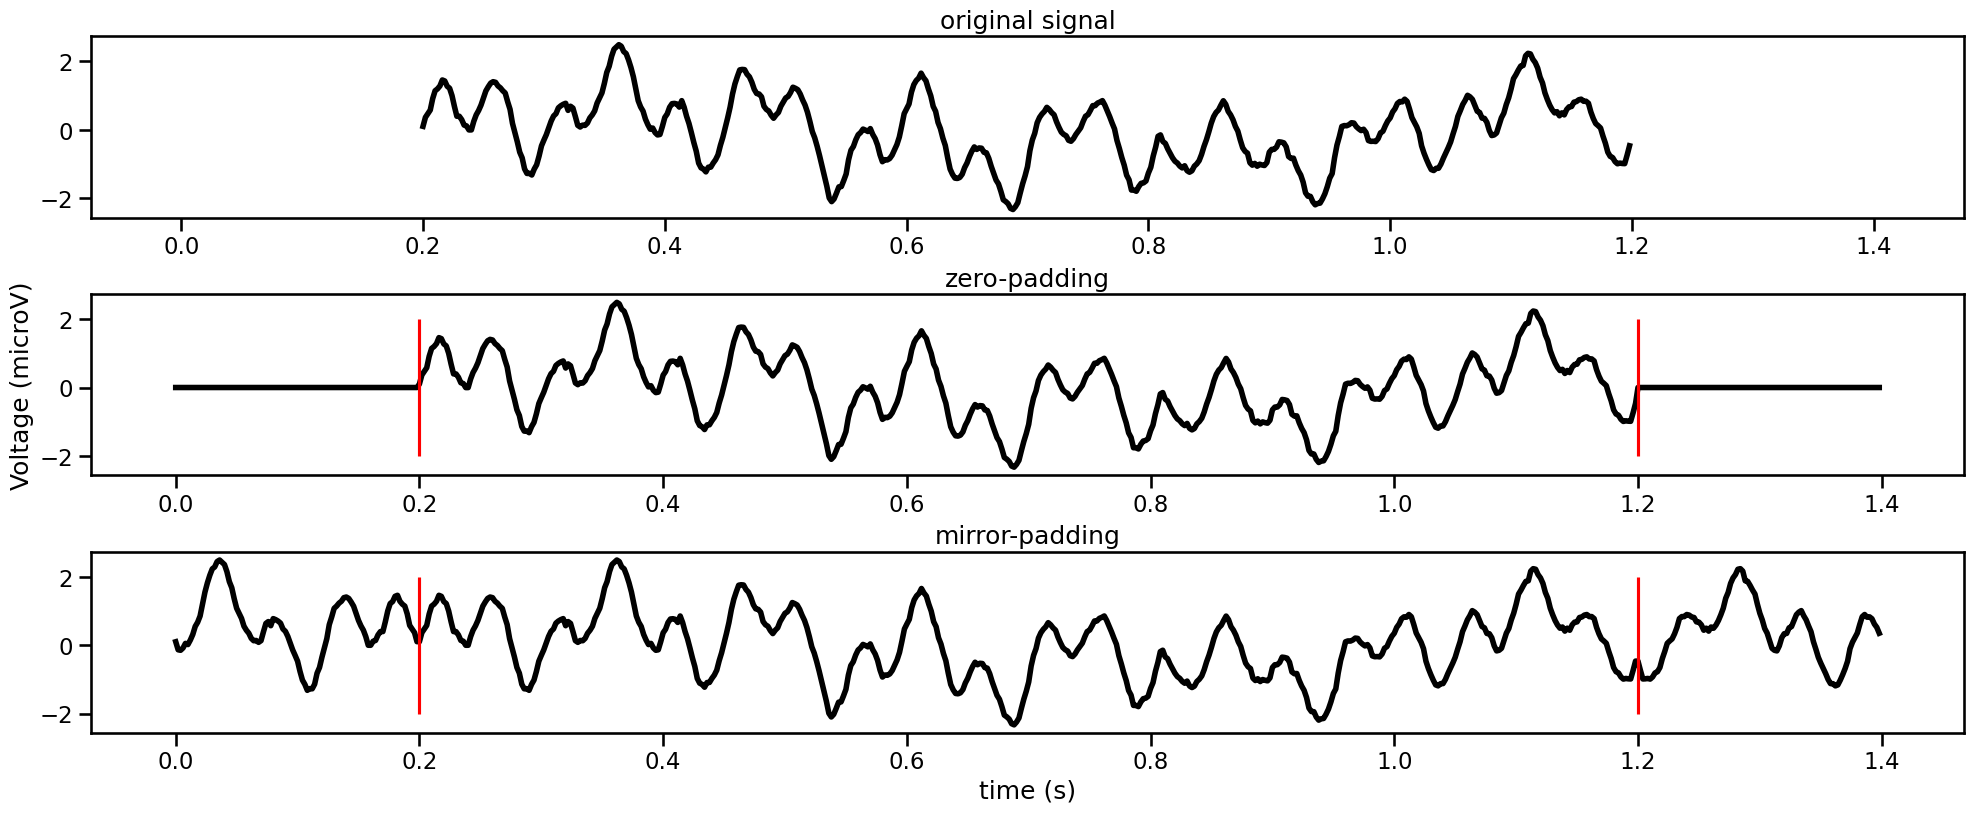

In [14]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=[20, 8])
fig.tight_layout()

axs[0].plot(times_pad, sig_ori, lw=4, color="black")
axs[1].plot(times_pad, sig_zero, lw=4, color="black")
axs[2].plot(times_pad, sig_mirror, lw=4, color="black")

# Change x-axis limit for original signal
axs[0].set_xlim([-0.075, 1.475])

# Add vertical line
axs[1].vlines(0.2, -2, 2, color="red")
axs[1].vlines(1.2, -2, 2, color="red")
axs[2].vlines(0.2, -2, 2, color="red")
axs[2].vlines(1.2, -2, 2, color="red")

axs[0].set_title("original signal")
axs[1].set_title("zero-padding")
axs[2].set_title("mirror-padding")

axs[2].set_xlabel("time (s)")
axs[1].set_ylabel("Voltage (microV)")


plt.show()

----------------------------------

## Figure x in paper (Belonging to Recommendation 3)

### Generate PSD with & without Knee

/Users/benderas/Documents/UCSD/Voytek/Repositories/AperiodicMethods/.env/lib/python3.11/site-packages/neurodsp/sim/transients.py:67: UserWarning: Rise time constant should be shorter than decay time constant.
  warn('Rise time constant should be shorter than decay time constant.')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


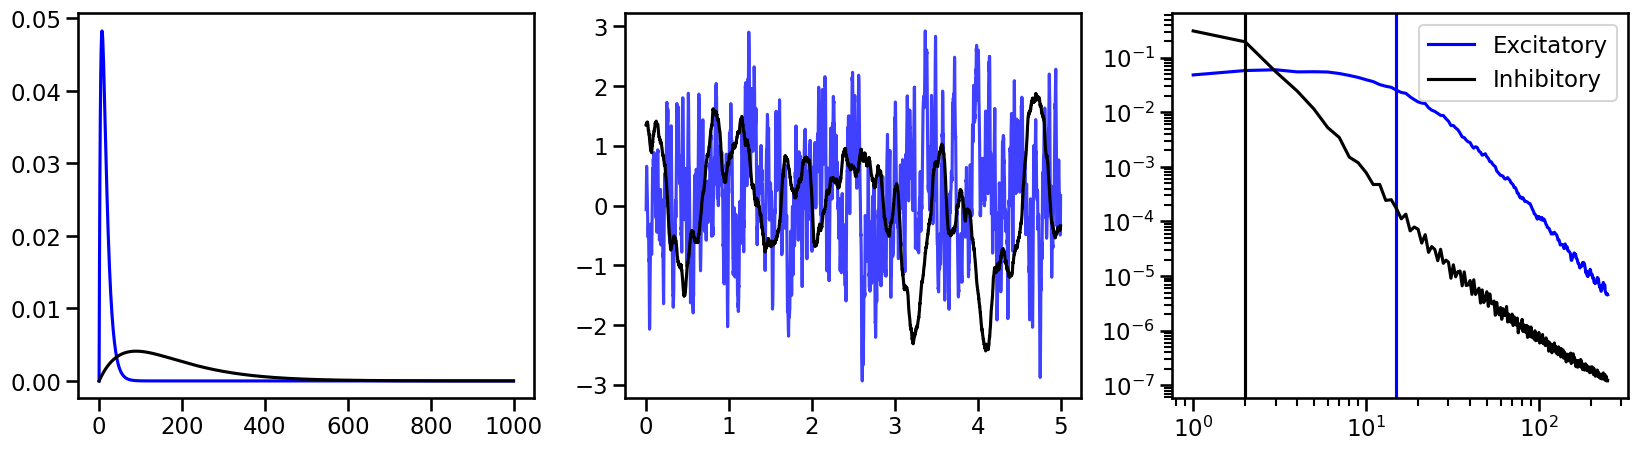

In [15]:
highKnee = 15
lowKnee = 2

tau_E = (0.005, (1 / (2 * np.pi * highKnee)))  # rise, decay
tau_I = (0.1, (1 / (2 * np.pi * lowKnee)))  # rise, decay
n_E = 8000
n_I = 2000
firRate_E = 2  # Hz
firRate_I = 2  # Hz
scale_I = 1
n_seconds = 200
fs = 1000
f_range = (1, 250)


fig, ax = plt.subplots(1, 3, figsize=(20, 5))

## Simulate synaptic kernels with slower and faster rise/decay rates
sig_E_ker = sim_synaptic_kernel(
    n_seconds=1, fs=fs, tau_r=tau_E[0], tau_d=tau_E[1]
)
sig_I_ker = sim_synaptic_kernel(
    n_seconds=1, fs=fs, tau_r=tau_I[0], tau_d=tau_I[1]
)

ax[0].plot(sig_E_ker, label="Excitatory", color="b")
ax[0].plot(sig_I_ker, label="Inhibitory", color="k")
plt.legend()

## Use these to simulate currents from both of these; this will give us a slower (inhibitory) signal, and a faster (excitatory) one
sig_E = sim_synaptic_current(
    n_seconds=n_seconds,
    fs=fs,
    n_neurons=n_E,
    firing_rate=firRate_E,
    tau_r=tau_E[0],
    tau_d=tau_E[1],
)
sig_I = (
    sim_synaptic_current(
        n_seconds=n_seconds,
        fs=fs,
        n_neurons=n_I,
        firing_rate=firRate_I,
        tau_r=tau_I[0],
        tau_d=tau_I[1],
    )
    * scale_I
)
time = np.arange(0, len(sig_E)) / fs
# only plotting the first 5 seconds for ease of vis
ax[1].plot(time[time < 5], sig_E[time < 5], label="E", alpha=0.75, color="b")
ax[1].plot(time[time < 5], sig_I[time < 5], label="I", color="k")

## Calc PSDs for each timeseries and plot; these should have different knees
freqs_fast, powers_fast = compute_spectrum(
    sig_E, fs, f_range=f_range, avg_type="mean", nperseg=fs, noverlap=fs / 2
)
freqs_slow, powers_slow = compute_spectrum(
    sig_I, fs, f_range=f_range, avg_type="mean", nperseg=fs, noverlap=fs / 2
)

ax[2].loglog(freqs_fast, powers_fast, label="Excitatory", color="b")
ax[2].axvline(highKnee, color="b")
ax[2].loglog(freqs_slow, powers_slow, label="Inhibitory", color="k")
ax[2].axvline(lowKnee, color="k")

plt.legend()

Text(0, 0.5, 'Powers (log)')

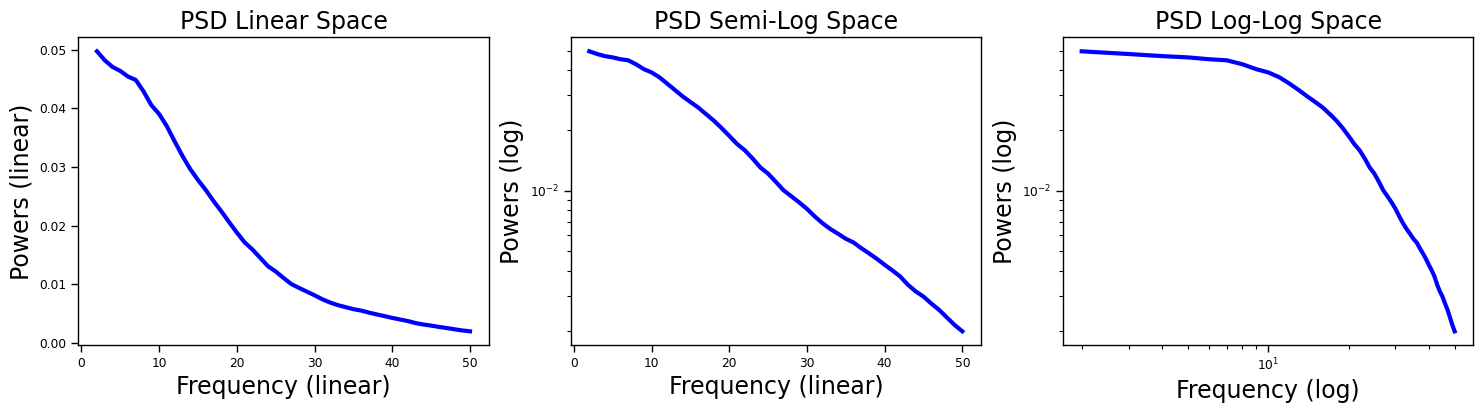

In [16]:
sns.set_context("paper")
highKnee = 20
tau_E = (0.005, (1 / (2 * np.pi * highKnee)))  # rise, decay
n_E = 10000
firRate_E = 10  # Hz
n_seconds = 5000
fs = 1000
f_range = (2, 50)


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
labels_size = 17
linewidth = 3

## Use these to simulate currents from both of these; this will give us a slower (inhibitory) signal, and a faster (excitatory) one
sig_E = sim_synaptic_current(
    n_seconds=n_seconds,
    fs=fs,
    n_neurons=n_E,
    firing_rate=firRate_E,
    tau_r=tau_E[0],
    tau_d=tau_E[1],
)

## Calc PSDs for each timeseries and plot; these should have different knees
freqs_fast, powers_fast = compute_spectrum(
    sig_E, fs, f_range=f_range, avg_type="mean", nperseg=fs, noverlap=fs / 2
)

ax[0].set_title("PSD Linear Space", fontsize=labels_size)
ax[0].plot(
    freqs_fast,
    powers_fast,
    label=f"Knee Freq: {highKnee}",
    color="b",
    linewidth=linewidth,
)
ax[0].set_xlabel("Frequency (linear)", fontsize=labels_size)
ax[0].set_ylabel("Powers (linear)", fontsize=labels_size)
# ax[0].axvline(highKnee, color='b')
# plt.legend()
# plt.show()

ax[1].set_title("PSD Semi-Log Space", fontsize=labels_size)
ax[1].semilogy(
    freqs_fast,
    powers_fast,
    label=f"Knee Freq: {highKnee}",
    color="b",
    linewidth=linewidth,
)
ax[1].set_xlabel("Frequency (linear)", fontsize=labels_size)
ax[1].set_ylabel("Powers (log)", fontsize=labels_size)
# ax[1].axvline(highKnee, color='b')

ax[2].set_title("PSD Log-Log Space", fontsize=labels_size)
ax[2].loglog(
    freqs_fast,
    powers_fast,
    label=f"Knee Freq: {highKnee}",
    color="b",
    linewidth=linewidth,
)
ax[2].set_xlabel("Frequency (log)", fontsize=labels_size)
ax[2].set_ylabel("Powers (log)", fontsize=labels_size)
# ax[2].axvline(highKnee, color='b')
# plt.legend()

Text(0.5, 1.0, 'Aperiodic Mode: Knee\n R-Squared: 1.0')

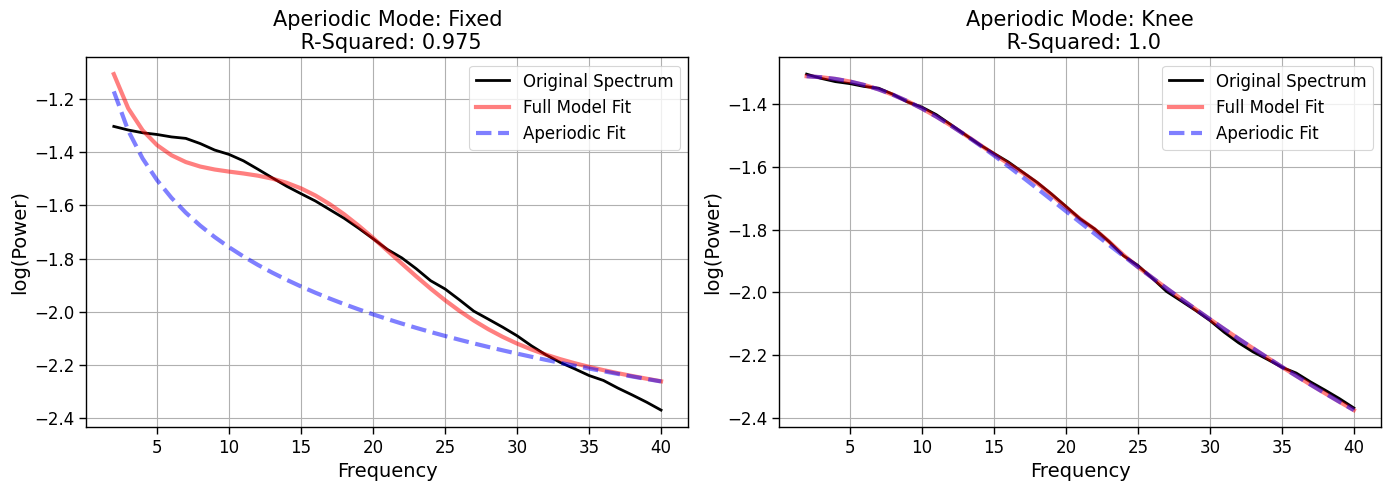

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
labels_size = 15

fit_settings = {"freq_range": (1, 40)}
init_settings = {
    "peak_width_limits": (2, 14),
    "peak_threshold": 2,
    "max_n_peaks": 4,
}

init_settings["aperiodic_mode"] = "fixed"
fm_f = fooof.FOOOF(**init_settings)
fm_f.fit(freqs=freqs_fast, power_spectrum=powers_fast, **fit_settings)
# exp = np.round(fm.get_results().aperiodic_params[1], decimals=3)
# frange = ax_dict[i]['freq_range']
fm_f.plot(ax=ax[0])
ax[0].set_title(
    f"Aperiodic Mode: Fixed\n R-Squared: {np.round(fm_f.r_squared_, decimals=3)}",
    fontsize=labels_size,
)

init_settings["aperiodic_mode"] = "knee"
fm_k = fooof.FOOOF(**init_settings)
fm_k.fit(freqs=freqs_fast, power_spectrum=powers_fast, **fit_settings)
# exp = np.round(fm.get_results().aperiodic_params[1], decimals=3)
# frange = ax_dict[i]['freq_range']
fm_k.plot(ax=ax[1])
ax[1].set_title(
    f"Aperiodic Mode: Knee\n R-Squared: {np.round(fm_k.r_squared_, decimals=3)}",
    fontsize=labels_size,
)

## Figure x in paper (Belonging to Recommendation 4)

### Set parameters for this section

In [18]:
# Simulation parameters
N_SECONDS = 2
FS = 1000
FREQ = 10
AMP1 = 1
AMP2 = 0.25
EXPONENT = -2

# Fitting parameters
N_PEAKS = 4
PEAK_WIDTH_LIMS = (2, 8)
FMIN = 2
FMAX = 50
ALPHA_BAND = (8, 12)

# Plotting parameters
PARAMS_TO_PLOT = {
    "logTotAUC": {
        "name": "Alpha total power (dense)",
        "color": "#ccbae0",
    },
    "logOscAUC": {
        "name": "Alpha oscillatory power (dense)",
        "color": "#7847ac",
    },
    "PW": {
        "name": "Alpha oscillatory power (sparse)",
        "color": "#0f0915",
    },
    "exponent": {
        "name": "Aperiodic exponent",
        "color": "#e66101",
    },
}

### Generate time series with alpha

In [19]:
def sim_and_plot_bursty_oscillation(
    n_seconds=N_SECONDS,
    fs=FS,
    freq=FREQ,
    amp1=AMP1,
    amp2=AMP2,
    exponent=EXPONENT,
    ax=None,
):
    # Define the components of the combined signal to simulate
    times = create_times(n_seconds, fs)
    osc1 = sim_oscillation(0.25 * n_seconds, fs, freq=freq)
    osc2 = sim_oscillation(0.25 * n_seconds, fs, freq=freq)
    aperiodic = sim_powerlaw(n_seconds, fs, exponent=exponent)

    # Simulate a combined signal with multiple oscillations
    osc1_padded = np.concatenate((osc1, np.zeros(int(0.75 * n_seconds * fs))))
    osc2_padded = np.concatenate((np.zeros(int(0.75 * n_seconds * fs)), osc2))
    sig = amp1 * osc1_padded + amp2 * osc2_padded + aperiodic

    # Define the true amplitudes of the oscillations
    true_amp1 = np.full(int(0.25 * n_seconds * fs), amp1)
    true_amp2 = np.full(int(0.25 * n_seconds * fs), amp2)
    true_amp = np.concatenate(
        (true_amp1, np.zeros(int(0.5 * n_seconds * fs)), true_amp2)
    )

    # Plot the simulated data, in the time domain
    plot_time_series(times, sig, ax=ax)
    sns.despine(ax=ax)
    return sig, freqs, times, true_amp

In [20]:
def compute_and_plot_tfr(
    sig, freqs, times, fs, tps=None, colors=None, ax=None
):
    # Compute PSD using the multitaper method
    tfr = tfr_array_multitaper(
        sig[np.newaxis, np.newaxis, :],
        sfreq=fs,
        freqs=freqs,
        n_cycles=freqs / 2,
        time_bandwidth=2.0,
        output="power",
    )

    # Extract TFR (squeeze unnecessary dimensions)
    tfr_power = tfr.squeeze()  # Shape becomes (n_frequencies, n_times)

    # Define the time axis
    time = np.arange(0, len(times)) / fs  # Time in seconds

    # Plot the TFR
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.imshow(
        tfr_power,
        aspect="auto",
        extent=[time[0], time[-1], freqs[0], freqs[-1]],
        origin="lower",
        cmap="magma",
    )
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Frequency (Hz)")
    ax.set_title("Time-Frequency Representation (Multitaper)")

    # Plot time points of interest
    if tps is not None:
        colors = ["white"] * len(tps) if colors is None else colors
        for tp, c in zip(tps, colors):
            ax.axvline(tp, color=c, linestyle="--")
    return tfr

In [21]:
def plot_sparam_psd(
    tfr,
    times,
    freqs,
    n_peaks=N_PEAKS,
    peak_width_lims=PEAK_WIDTH_LIMS,
    fmin=FMIN,
    fmax=FMAX,
    alpha_band=ALPHA_BAND,
    params_to_plot=PARAMS_TO_PLOT,
    tp=0.5,
    background_color="white",
    ax=None,
):
    """Plot spectral parameterization."""
    # Copy to avoid modifying the original data
    tfr = tfr.copy()
    times = times.copy()
    freqs = freqs.copy()

    # Create figure and axis if not provided
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(6, 6))

    # Compute spectral parameterization
    tp_idx = np.argmin(np.abs(times - tp))
    powers = tfr[0, 0, :, tp_idx]
    fm = fooof.FOOOF(
        max_n_peaks=n_peaks, peak_width_limits=peak_width_lims, verbose=False
    )
    fm.fit(freqs, powers, freq_range=(fmin, fmax))

    # Determine indices for alpha band in frequencies array
    low_freq_idx = np.argmin(np.abs(freqs - alpha_band[0]))
    high_freq_idx = np.argmin(np.abs(freqs - alpha_band[1]))

    # Plot PSD
    plot_spectra(freqs, np.log10(powers), ax=ax, c="k")

    # Plot exponent fit
    plot_spectra(
        freqs[: len(fm._ap_fit)],
        fm._ap_fit,
        freq_range=(fmin, fmax),
        ax=ax,
        c=params_to_plot["exponent"]["color"],
        ls="--",
        label=params_to_plot["exponent"]["name"],
    )

    # Plot AUC measure for band
    y_min, y_max = ax.get_ylim()
    ax.fill_between(
        freqs[low_freq_idx : high_freq_idx + 1],
        fm._ap_fit[low_freq_idx : high_freq_idx + 1],
        y2=np.log10(powers)[low_freq_idx : high_freq_idx + 1],
        color=params_to_plot["logOscAUC"]["color"],
        alpha=0.9,
        label=params_to_plot["logOscAUC"]["name"],
    )
    ax.fill_between(
        freqs[low_freq_idx : high_freq_idx + 1],
        y_min,
        y2=np.log10(powers)[low_freq_idx : high_freq_idx + 1],
        color=params_to_plot["logTotAUC"]["color"],
        alpha=0.5,
        label=params_to_plot["logTotAUC"]["name"],
    )

    # Plot greek character
    ax.text(
        (freqs[low_freq_idx] + freqs[high_freq_idx]) / 2,
        1.1 * y_max,
        rf'$\{params_to_plot["logOscAUC"]["name"].split()[0].lower()}$',
        fontsize=24,
        color=params_to_plot["logOscAUC"]["color"],
        va="top",
        ha="center",
    )

    # Plot bands
    ax.fill_betweenx(
        [y_min, 1.3 * y_max],
        freqs[low_freq_idx],
        freqs[high_freq_idx],
        facecolor=params_to_plot["logTotAUC"]["color"],
        alpha=0.2,
    )

    # Plot arrow for alpha PW
    ax.annotate(
        "",
        xy=(
            freqs[(low_freq_idx + high_freq_idx) // 2],
            fm._ap_fit[
                (low_freq_idx + high_freq_idx) // 2
            ],  # Use a single value
        ),
        xytext=(
            freqs[(low_freq_idx + high_freq_idx) // 2],
            np.log10(powers)[
                (low_freq_idx + high_freq_idx) // 2
            ],  # Use a single value
        ),
        arrowprops=dict(
            arrowstyle="<->", color=params_to_plot["PW"]["color"], lw=4
        ),
        label=params_to_plot["PW"]["name"],
    )

    # Retrieve existing legend handles and labels
    handles, labels = ax.get_legend_handles_labels()

    # Add a custom handle for the arrow
    custom_line = Line2D(
        [0],
        [0],
        color=params_to_plot["PW"]["color"],
        lw=4,
        label=params_to_plot["PW"]["name"],
    )
    handles.append(custom_line)
    labels.append(params_to_plot["PW"]["name"])

    # Plot background color
    rect = plt.Rectangle(
        (fmin, y_min),
        fmax - fmin,
        1.3 * y_max - y_min,
        color=background_color,
        alpha=0.1,
        zorder=-1,
    )
    ax.add_patch(rect)

    # Plot time point
    if tp is not None:
        t_color = "k" if background_color == "white" else background_color
        space_above = 1.3 * y_max - np.median(np.log10(powers))
        y = 0.5 * space_above + np.median(np.log10(powers))
        ax.text(
            np.median(freqs),
            y,
            f"$t={tp}$",
            fontsize=15,
            color=t_color,
            va="top",
            ha="center",
        )

    # Plot aesthetics
    ax.set_ylim([y_min, 1.3 * y_max])
    ax.grid(False)
    sns.despine(ax=ax)
    ax.legend(handles=handles, labels=labels, loc="upper right")
    return

In [22]:
def compute_and_plot_sliding_window_params(
    tfr,
    times,
    freqs,
    n_peaks=N_PEAKS,
    peak_width_lims=PEAK_WIDTH_LIMS,
    fmin=FMIN,
    fmax=FMAX,
    alpha_band=ALPHA_BAND,
    params_to_plot=PARAMS_TO_PLOT,
    ax=None,
    true_amp=None,
):
    # Copy to avoid modifying the original data
    tfr = tfr.copy()
    times = times.copy()
    freqs = freqs.copy()

    # Compute spectral parameterization
    powers = tfr[0, 0, :, :]
    fg = fooof.FOOOFGroup(
        max_n_peaks=n_peaks, peak_width_limits=peak_width_lims, verbose=False
    )
    fg.fit(freqs, powers.T, freq_range=(fmin, fmax))

    # Extract aperiodic and model fit parameters from model
    aperiodic_params = fg.get_params("aperiodic_params")

    # Select only peak parameters with peak frequency in desired frequency
    # band
    peak_params = get_band_peak_fg(fg, alpha_band)

    # Initialize list of fitted models and area parameters
    area_params_dct = {
        "logOscAUC": None,
        "logTotAUC": None,
    }
    area_params = np.zeros((len(times), len(area_params_dct)))

    # Fit spectral parameterization model for one channel and time point
    for i in range(len(fg.group_results)):
        # Regenerate FOOOF model
        fm = fg.get_fooof(i)
        if not fm.has_model or not fm.has_data:
            print(0, fm.has_model, fm.has_data)
            continue
        # Determine all areas to extract
        area_params_dct["logOscAUC"] = fm.power_spectrum - fm._ap_fit
        area_params_dct["logTotAUC"] = fm.power_spectrum
        area_params_one_psd = {}
        for param, spectra in area_params_dct.items():
            freqs_trim, psd_trim = trim_spectrum(
                freqs[: len(spectra)], spectra, alpha_band
            )
            area_params_one_psd[param] = np.trapz(psd_trim, freqs_trim)

        # Add values to area parameters array
        area_params[i] = np.array(
            [
                area_params_one_psd[k]
                for k in sorted(area_params_one_psd.keys())
            ]
        )

    # Put all parameters together
    model_params = np.hstack(
        (
            aperiodic_params,
            peak_params,
            area_params,
        )
    )

    # Create DataFrame for trial
    column_names = ["offset", "exponent", "CF", "PW", "BW"]
    column_names += sorted(area_params_dct.keys())
    sparam_df = pd.DataFrame(
        model_params, columns=column_names, index=times
    ).reset_index(names=["t"])

    # Make a plot
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10, 5))

    # Remove exponent from parameters to plot (if it's present)
    params_to_plot = params_to_plot.copy()
    params_to_plot.pop("exponent", None)

    # Plot each parameter
    for param, param_props in params_to_plot.items():
        # Fill NaNs with zeros
        param_ts = sparam_df[param].fillna(0)

        # Normalize the parameter
        param_ts = param_ts / param_ts.max()

        # Plot the parameter
        ax.plot(
            sparam_df["t"],
            param_ts,
            label=param_props["name"],
            color=param_props["color"],
        )

    # Plot true amplitudes
    if true_amp is not None:
        ax.plot(
            times,
            true_amp / np.max(true_amp),
            label="True oscillatory power",
            color="green",
            lw=4,
        )

    # Shade below zero line
    y_min, y_max = ax.get_ylim()
    ax.axhline(0, color="black", lw=1, ls="--")
    ax.fill_between(
        times,
        y_min,
        0,
        color="gray",
        alpha=0.2,
        label='"Negative" oscillations',
    )

    # Circle time points where true oscillations are present and PW is zero
    if true_amp is not None:
        # True oscillation, but no oscillation detected
        zero_pw = sparam_df["PW"].isna()
        true_osc = true_amp > 0
        mask = zero_pw & true_osc
        ax.scatter(
            sparam_df["t"][mask],
            np.zeros(mask.sum()),
            label="Oscillation missed",
            s=100,
            edgecolors="red",
            facecolors="none",
        )

    # Plot aesthetics
    ax.set_xlim([times[0], times[-1]])
    ax.set_ylim([y_min, y_max])
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Normalized parameter value")
    ax.legend()
    sns.despine(ax=ax)
    return

In [23]:
def add_letter_labels(axes, x=-0.1, y=1.05, size=28):
    """Add letter labels to figure."""
    for i, ax in enumerate(axes):
        label = string.ascii_uppercase[i]
        # Plot the label
        ax.text(
            x,
            y,
            "%s" % label,
            transform=ax.transAxes,
            size=size,
            weight="bold",
        )

/var/folders/5j/h9q625yn13vfynsjc2bymdy00000gn/T/ipykernel_68867/1778602161.py:112: UserWarning: Legend does not support handles for Annotation instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()
/var/folders/5j/h9q625yn13vfynsjc2bymdy00000gn/T/ipykernel_68867/1778602161.py:112: UserWarning: Legend does not support handles for Annotation instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()
/var/folders/5j/h9q625yn13vfynsjc2bymdy00000gn/T/ipykernel_68867/1778602161.py:112: UserWarning: Legend does not support handles for Annotation instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


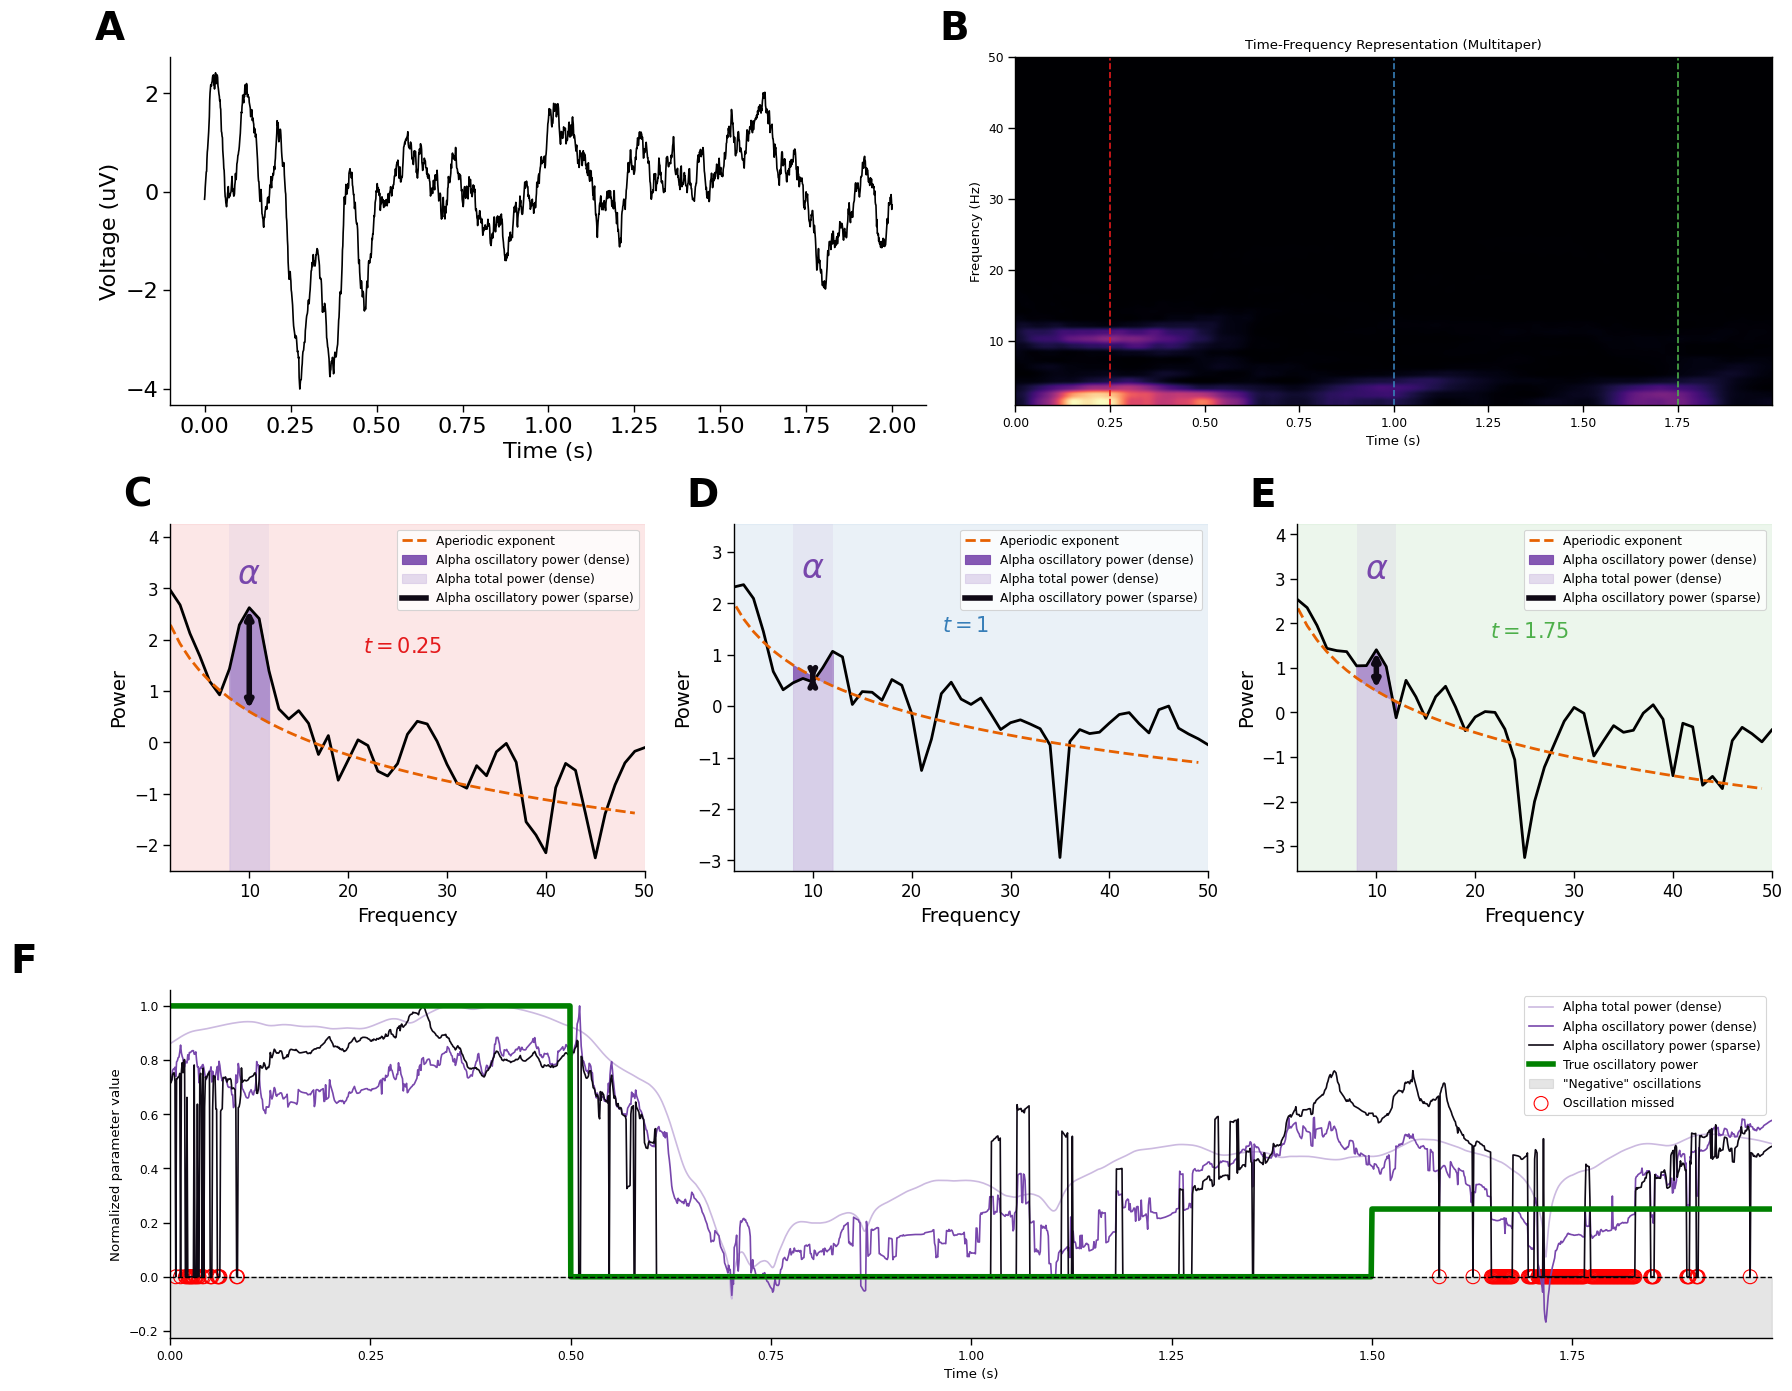

In [24]:
# Make figure
fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(3, 6)

# Simulate and plot bursty oscillation
ax_ts = fig.add_subplot(gs[0, :3])
sig, freqs, times, true_amp = sim_and_plot_bursty_oscillation(ax=ax_ts)

# Compute and plot TFR
ax_tfr = fig.add_subplot(gs[0, 3:])
tps = [0.25, 1, 1.75]
colors = sns.color_palette("Set1", len(tps))
tfr = compute_and_plot_tfr(
    sig, freqs, times, fs, tps=tps, colors=colors, ax=ax_tfr
)

# Plot spectral parameterization
axes_sp = []
for i, (tp, c) in enumerate(zip(tps, colors)):
    ax = fig.add_subplot(gs[1, 2 * i : 2 * (i + 1)])
    axes_sp.append(ax)
    plot_sparam_psd(tfr, times, freqs, ax=ax, tp=tp, background_color=c)

# Compute and plot sliding window parameters
ax_sw = fig.add_subplot(gs[2, :])
compute_and_plot_sliding_window_params(
    tfr, times, freqs, true_amp=true_amp, ax=ax_sw
)

# Add letter labels
axes = [ax_ts, ax_tfr, *axes_sp, ax_sw]
add_letter_labels(axes)

# Save out the figure
if SAVE_FIG:
    os.makedirs(FIG_DIR, exist_ok=True)
    plt.savefig(
        f"{FIG_DIR}/rec4_missing_oscillations.png",
        dpi=300,
        bbox_inches="tight",
    )

### Conclusion

<>